In [10]:
# importing necessary libraties

import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# reading the data as data frames
prob_df = pd.read_csv('celegans_cpat.ORF_prob.tsv',sep='\t')
prob_df.head()

,ID,mRNA,ORF_strand,ORF_frame,ORF_start,ORF_end,ORF,Fickett,Hexamer,Coding_prob
0,STRG.1.1_ORF_1,824,+,2,383,817,435,0.5708,-0.318339,2.220446e-16
1,STRG.1.1_ORF_2,824,-,3,708,526,183,0.9016,-0.231334,2.220446e-16
2,STRG.1.1_ORF_3,824,-,3,117,1,117,0.6936,0.088833,2.220446e-16
3,STRG.1.1_ORF_4,824,+,1,277,357,81,1.0410,-0.315670,2.220446e-16
4,STRG.1.1_ORF_5,824,+,2,182,259,78,1.0471,-0.301856,2.220446e-16


C:\Users\ajaye\AppData\Local\Temp\ipykernel_16216\3901862039.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=prob_df.Coding_prob, bins = 10)


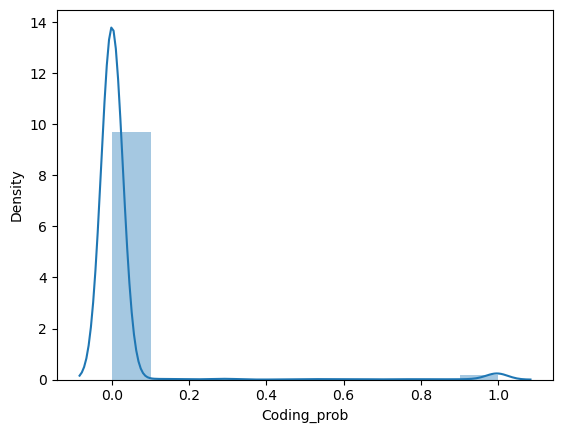

In [12]:
# draw a histogram to see the probability distribution

sns.distplot(a=prob_df.Coding_prob, bins = 10)
plt.show()

In [16]:
# filtering the columns that have probability greater than 0.4
filtered_df = prob_df[prob_df['Coding_prob'] < 0.4]
filtered_df.head()

,ID,mRNA,ORF_strand,ORF_frame,ORF_start,ORF_end,ORF,Fickett,Hexamer,Coding_prob
0,STRG.1.1_ORF_1,824,+,2,383,817,435,0.5708,-0.318339,2.220446e-16
1,STRG.1.1_ORF_2,824,-,3,708,526,183,0.9016,-0.231334,2.220446e-16
2,STRG.1.1_ORF_3,824,-,3,117,1,117,0.6936,0.088833,2.220446e-16
3,STRG.1.1_ORF_4,824,+,1,277,357,81,1.0410,-0.315670,2.220446e-16
4,STRG.1.1_ORF_5,824,+,2,182,259,78,1.0471,-0.301856,2.220446e-16


In [18]:
# getting the transcript ID from the ID column by removing the ORF information
transcript_ids = list(set([re.sub(r'_ORF_\d+$', '', item) for item in filtered_df['ID']]))
len(transcript_ids)

767

In [20]:

#printing just the first 5 elements to see if the right ID has been captured
print(transcript_ids[:5])

['STRG.14560.2', 'STRG.2457.3', 'STRG.1504.4', 'STRG.1919.2', 'STRG.4530.1']


In [22]:
# extracting the IDs for which there are no ORFs

with open("celegans_CPAT_run_info.log", "r") as file:
    lines = file.readlines()

ids_no_orfs = []
for line in lines:
    match = re.search(r"No ORFs found for (\S+)", line)
    if match:
        ids_no_orfs.append(match.group(1))

# print(ids)
len(ids_no_orfs)

13

In [24]:
#merging the transcript_ids tor the ids_no_orfs into one list
final_lncrna_transcripts = transcript_ids + ids_no_orfs
final_lncrna_transcripts = [item.replace("BATCH", "batch") for item in final_lncrna_transcripts]
len(final_lncrna_transcripts)


780

In [26]:
# check if there are any duplicates in the final list
len(final_lncrna_transcripts) != len(set(final_lncrna_transcripts))

False

In [28]:
# Extracting the list into a .txt file
with open("celegans_final_lncrna_cpat_manual.txt", "w") as file:
    for item in final_lncrna_transcripts:
        file.write(item + "\n")

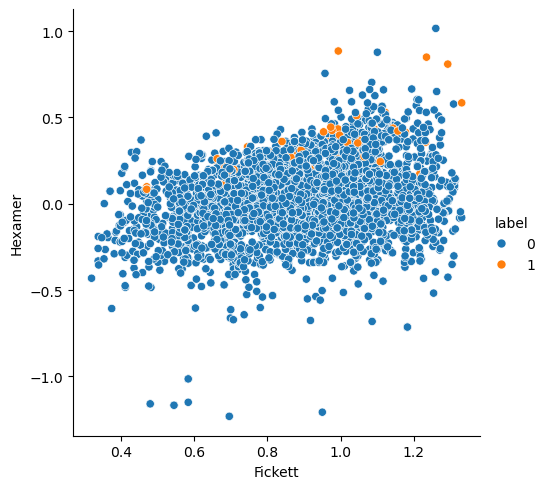

In [30]:
# Including a new column called label specifying coding(1) or non-coding(0) based on the probability
prob_df['label'] = (prob_df['Coding_prob'] > 0.4).astype(int)

# plotting the hexamer score against the fickett score to get a scatter plot
sns.relplot(data=prob_df, x="Fickett", y="Hexamer", hue = 'label')

In [32]:
# PCA analysis
# preprocessing the data 
from sklearn.preprocessing import StandardScaler

features = ['mRNA','ORF','Fickett','Hexamer']

# Separating out the features
x = prob_df.loc[:, features].values
y = prob_df.iloc[:, 10].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# Run PCA with 2 components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [38]:
# Concatenating DataFrame along axis = 1. finalDf is the final DataFrame before plotting the data.
finalDf = pd.concat([principalDf, prob_df[['label']]], axis = 1)

# printing the variance explained by each PC
explained_variance = pca.explained_variance_ratio_ * 100
print("Percentage of variance explained by each principal component:")
for i, variance in enumerate(explained_variance, start=1):
    print(f"Principal Component {i}: {variance:.2f}%")

Percentage of variance explained by each principal component:
Principal Component 1: 44.66%
Principal Component 2: 24.69%


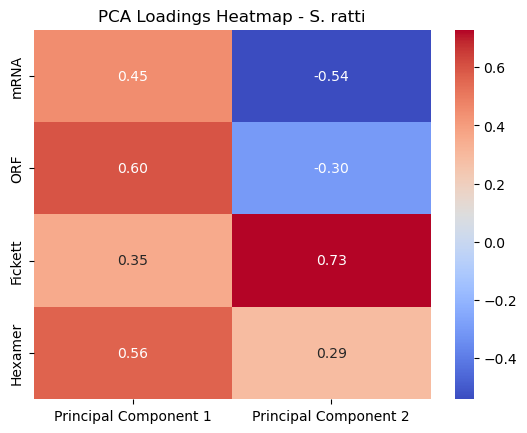

In [40]:
# create a heatmap for the loading scores for each variable
import matplotlib.pyplot as plt

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['Principal Component 1', 'Principal Component 2'],
                       index=features)
sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("PCA Loadings Heatmap - S. ratti")
plt.show()

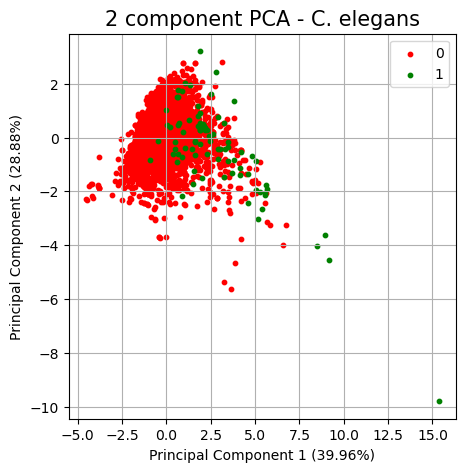

In [42]:
# creating a PCA plot
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1 (39.96%)', fontsize = 10)
ax.set_ylabel('Principal Component 2 (28.88%)', fontsize = 10)
ax.set_title('2 component PCA - C. elegans', fontsize = 15)

targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()